**Install and Import packages**

In [153]:
!pip3 install networkx pyvis


In [154]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import importlib
from matplotlib import pyplot as plt
from collections import deque
import nest_asyncio
import heapq
from itertools import combinations
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import random

nest_asyncio.apply()

**Download a Dataset**

In [155]:
dataset_path = "/kaggle/input/usa-airport-dataset/Airports2.csv"
airports_df = pd.read_csv(dataset_path)

**Dataset Info**

In [156]:
airports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


In [157]:
airports_df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


## 3. Finding Best Routes (Q3)
Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system you are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.

- In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

__Note__: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city $A$ has airports $a_1, a_2$ and  city B has $b_1, b_2$, the function should compute the best routes for $a_1 \rightarrow b_1$, $a_1 \rightarrow b_2$, $a_2 \rightarrow b_1$ and $a_2 \rightarrow b_2$. If it’s not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:
1. Flights network
2. Origin city name
3. Destination city name
4. Considered Date (in yyyy-mm-dd format)

The function output:
1. A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.

__Note__: In the "Best_route" column, we expect a list of airport names connected by $\rightarrow$, showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."

### **Create Weighted Net**
For this task was created a weighted flights' directed graph where weights are `Distance` between `Origin_airport` and `Destination_airport`.

In [158]:
weighted_flight_net = nx.DiGraph()
    
# Add edges into net
for _, row in airports_df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    # Use distance as weight
    distance = row['Distance']
        
    # Add the edge with distance as the weight
    weighted_flight_net.add_edge(origin, destination, weight=distance)

To verify correctness of created graph let's show nodes and adges that are stored now in `weighted_flight_net`.

In [159]:
print("Nodes:", list(weighted_flight_net.nodes())[:10])
print("Edges:", list(weighted_flight_net.edges(data=True))[:10])

Nodes: ['MHK', 'AMW', 'EUG', 'RDM', 'MFR', 'SEA', 'PDX', 'LMT', 'SFO', 'LAX']
Edges: [('MHK', 'AMW', {'weight': 254}), ('MHK', 'HYS', {'weight': 142}), ('MHK', 'ACT', {'weight': 520}), ('MHK', 'CAK', {'weight': 816}), ('MHK', 'FAR', {'weight': 537}), ('MHK', 'MIA', {'weight': 1323}), ('MHK', 'TMB', {'weight': 1325}), ('MHK', 'OFF', {'weight': 142}), ('MHK', 'TUL', {'weight': 208}), ('MHK', 'AUS', {'weight': 619})]


### **Create `find_best_route` function**

Preseudocode of **Dijkstra alghoritm** to find shortest path from the source node to the target node.

```plaintext
Function DijkstraShortestPath(graph, source, target)
"""
Dijkstra's Algorithm to find the shortest path and its length.

Parameters:
    graph: Weighted directed flight network.
    source: Starting node (origin airport).
    target: Destination node (destination airport).

Returns:
    path: List of nodes in the shortest path from origin airport to destination airport.
    total_distance: Total distance of the shortest path.
"""
    # Create priority queue: [(current_distance, current_node, path)]
    pq ← [(0, source, [])]
    # Initialize a dictionary to store visited nodes and their distances
    visited ← {}

    # Iterate priority queue while there is no nodes in it
    While pq is not empty:
        # Pop node with the smallest edge weight (Distance)
        current_distance, current_node, path ← HeapPop(pq)

        # Skip the node if it has already been visited
        If current_node is visited:
            Continue
        End If

        # Mark the current node as visited and store its distance
        visited[current_node] ← current_distance

        # Add the current node to the visited path
        path ← path + [current_node]

        # If the target node is reached, return the path and total distance
        If current_node == target:
            Return path, current_distance

        # Explore all neighbors of the current node
        For each neighbor in current_node's neighbors:
            If neighbor is not visited:
                # Retrieve the edge weight from current_node to neighbor
                edge_weight ← graph[current_node][neighbor].Get('weight', ∞)

                # Push the neighbor's node into the priority queue with the updated distance
                HeapPush(pq, (current_distance + edge_weight, neighbor, path))

    # If no path exists from source to target, return None for the path and infinity for the distance.
    Return None, ∞
End Function
```

**Sources**:
- Graph Data Structure 4. Dijkstra’s Shortest Path Algorithm: https://youtu.be/pVfj6mxhdMw?si=_oNn0vGPPOv5G4H8

In [160]:
def dijkstra_shortest_path(graph, source, target):
    """
    Dijkstra's Algorithm to find the shortest path and its length.

    Parameters:
        graph: wightted directed flight network.
        source: Starting node (origin airport).
        target: Destination node (destination airport).

    Returns:
        path: List of nodes in the shortest path from origin airport to destination airport.
        total_distance: Total distance of the shortest path.
    """
    # Priority queue that stores: [(current_distance, current_node, path)]
    # Example: 
    # [(0, 'AMW', [])]
    # [(254, 'MHK', ['AMW'])]
    # [(310, 'FOE', ['AMW', 'MHK']), (312, 'SLN', ['AMW', 'MHK']), (372, 'LNK', ['AMW', 'MHK']), ...]
    pq = [(0, source, [])]
    
    # Dictionary with visited nodes
    visited = {}

    while pq:
        # print(pq)
        # Get the node with the smallest distance
        current_distance, current_node, path = heapq.heappop(pq)
        
        # Skip the node if it has already been visited
        if current_node in visited:
            continue
        
        # Mark the current node as visited
        visited[current_node] = current_distance
        
        # Add the current node to the path
        path = path + [current_node]
        
        # If the target node is reached, return the path and total distance
        if current_node == target:
            return path, current_distance
        
        # Explore neighbors of the current node
        for neighbor in graph.neighbors(current_node):
            # If the neighbor hasn't been visited
            if neighbor not in visited:
                # Retrieve the distance of the edge from current_node to neighbor
                edge_weight = graph[current_node][neighbor].get('weight', float('inf'))
                
                # Push the neighbor into the priority queue with the updated distance
                heapq.heappush(pq, (current_distance + edge_weight, neighbor, path))
    
    # If no path exists, return None and infinity for the distance
    return None, float('inf')

To test it on sample were picked `Origin_airport="AMW"` and `Destination_airport="HYS"`. The function's output is a tuple of the ordered list with nodes of the shortest path and the total distance.

In [161]:
origin = "AMW"
destination = "HYS"
dijkstra_shortest_path(weighted_flight_net, origin, destination)

(['AMW', 'MHK', 'HYS'], 396)

### **Steps to find shortest path from origin to destination city**

1. Filter input flight gragh by date.
2. Find all available airports from `Origin_city` and airports from `Destination_city` on chosen date.
3. For all possible combinations of airports from `Origin_city` to `Destination_city` find shortest path using **Dijkstra's Algorithm**.
4. Find minimum distance path among retrieved destinations.


In [162]:
def filter_cities_by_date(flight_net, date):
    """
    Filters the flight network to include only the flights available on the specified date.

    Parameters:
        flight_net (networkx.Graph): The complete flight network graph.
        date (str): The date to filter the graph (in yyyy-mm-dd format).

    Returns:
        networkx.Graph: A subgraph of the flight network containing only flights on the specified date.
    """
    # Filter cities by date
    cities_filtered = airports_df[airports_df["Fly_date"] == date][["Origin_airport", "Destination_airport"]]
    nodes_to_keep = pd.concat([cities_filtered["Origin_airport"], cities_filtered["Destination_airport"]]).unique()
    
    # Return the subgraph filtered by date
    return flight_net.subgraph(nodes_to_keep).copy()

def check_if_nodes_in_graph(nodes, graph_nodes, city, isOrigin):
    """
    Checks whether the given list of nodes exists in the graph and returns only the available nodes.

    Parameters:
        nodes (list): A list of node names to check.
        graph_nodes (list): The list of nodes available in the graph.
        city (str): The city name associated with the nodes.
        isOrigin (bool): Indicates whether the nodes are origin nodes (True) or destination nodes (False).

    Returns:
        list: A list of nodes available in the graph.
    """
    filtered_nodes = [node for node in nodes if node in graph_nodes]
    if len(filtered_nodes) != len(nodes):
        print(f"Airports that are not available from {'origin' if isOrigin else 'destination'} city '{city}': {set(nodes) - set(filtered_nodes)}")
    return filtered_nodes

def get_airports_by_city(city, graph_nodes, isOrigin=True):
    """
    Retrieves the list of airports in a specific city and checks their availability in the graph.

    Parameters:
        city (str): The name of the city.
        graph_nodes (list): The list of nodes available in the graph.
        isOrigin (bool): Indicates whether to retrieve origin airports (True) or destination airports (False).

    Returns:
        list: A list of airports in the specified city that are present in the graph.
    """
    if isOrigin:
        return check_if_nodes_in_graph(airports_df[airports_df["Origin_city"].str.strip() == city]["Origin_airport"].unique().tolist(), graph_nodes, city, isOrigin)
    else:
        return check_if_nodes_in_graph(airports_df[airports_df["Destination_city"].str.strip() == city]["Destination_airport"].unique().tolist(), graph_nodes, city, isOrigin)
    
def find_optimal_route_from_multiple(results):
    """
    Finds the optimal route(s) with the minimum total distance from the list of results.

    Parameters:
        results (list): A list of dictionaries, each containing:
                        - 'Origin_city_airport'
                        - 'Destination_city_airport'
                        - 'Best_route'
                        - 'Total_distance'

    Returns:
        pd.DataFrame: A DataFrame with the optimal routes.
    """
    # Filter out results with 'None' distances
    valid_results = [result for result in results if result['Total_distance'] is not None]

    if not valid_results:
        print("No valid routes found.")
        return pd.DataFrame([], columns=['Origin_city_airport', 'Destination_city_airport', 'Best_route'])
    
    # Find the minimum total distance among valid results
    min_distance = min(result['Total_distance'] for result in valid_results)

    # Find all results with the minimum total distance
    min_results = [result for result in valid_results if result['Total_distance'] == min_distance]

    return pd.DataFrame(min_results, columns=['Origin_city_airport', 'Destination_city_airport', 'Best_route'])

def find_best_route(flight_net, origin, destination, date):
    """
    Finds the best route(s) between the origin and destination cities for a given date.

    Parameters:
        flight_net (networkx.Graph): The flight network graph.
        origin (str): The origin city name.
        destination (str): The destination city name.
        date (str): The date to consider for the flight (in yyyy-mm-dd format).

    Returns:
        pd.DataFrame: A DataFrame containing the best route(s) with columns:
                      - 'Origin_city_airport'
                      - 'Destination_city_airport'
                      - 'Best_route'
    """
    print(f"Flight date: {date}")
    print(f"Total Graph Nodes in the Flight Net: {len(flight_net.nodes())}")
    
    # Create the subgraph filtered by date
    filtered_graph = filter_cities_by_date(flight_net, date)
    print(f"Available Graph Nodes: {len(filtered_graph.nodes())}")

    print("-" * 50)
    # Get all airports for origin and destination cities
    origin_airports = get_airports_by_city(origin, filtered_graph)
    destination_airports = get_airports_by_city(destination, filtered_graph, isOrigin=False)
    
    print(f"Origin airports in {origin}: {origin_airports}")
    print(f"Destination airports in {destination}: {destination_airports}")
    print("-" * 50)

    # Find the best routes
    print("All possible routes:")
    results = []
    for origin_airport in origin_airports:
        for destination_airport in destination_airports:
            try:
                # Find the shortest path using Dijkstra's algorithm
                path, total_distance = dijkstra_shortest_path(graph=filtered_graph, source=origin_airport, target=destination_airport)
                print(f"- Path from {origin_airport} to {destination_airport}: {path} ({total_distance})")
                
                # Append the route to results
                results.append({
                    'Origin_city_airport': origin_airport,
                    'Destination_city_airport': destination_airport,
                    'Best_route': ' → '.join(path) if path is not None else 'No route found',
                    'Total_distance': total_distance if path is not None else None
                })
            except Exception as e:
                print(f"Error finding path from {origin_airport} to {destination_airport}: {e}")
                results.append({
                    'Origin_city_airport': origin_airport,
                    'Destination_city_airport': destination_airport,
                    'Best_route': 'No route found',
                    'Total_distance': None
                })
    
    return find_optimal_route_from_multiple(results)

#### **Case: 'No route found'**

In `Origin_city` 'Aberdeen, SD' there is one airport 'ABR', but the flight is not available on date '1993-02-01'. The same is right also for `Destination_city` 'Zanesville, OH' - 'ZZV'.

In [163]:
find_best_route(weighted_flight_net, "Aberdeen, SD", "Zanesville, OH", "1993-02-01")


Flight date: 1993-02-01
Total Graph Nodes in the Flight Net: 727
Available Graph Nodes: 250
--------------------------------------------------
Airports that are not available from origin city 'Aberdeen, SD': {'ABR'}
Airports that are not available from destination city 'Zanesville, OH': {'ZZV'}
Origin airports in Aberdeen, SD: []
Destination airports in Zanesville, OH: []
--------------------------------------------------
All possible routes:
No valid routes found.


,Origin_city_airport,Destination_city_airport,Best_route


#### **Case: 'Route found'**
Both Origin and Destination cities have multiple airports. The function `find_best_route` is checking all possible combination and then picks the best route (with min distance) among them.

In [164]:
find_best_route(weighted_flight_net, "Anchorage, AK", "Chicago, IL", "1993-02-01")

Flight date: 1993-02-01
Total Graph Nodes in the Flight Net: 727
Available Graph Nodes: 250
--------------------------------------------------
Airports that are not available from origin city 'Anchorage, AK': {'MRI'}
Airports that are not available from destination city 'Chicago, IL': {'CHI', 'II2', 'PWK', 'DPA'}
Origin airports in Anchorage, AK: ['ANC', 'EDF']
Destination airports in Chicago, IL: ['ORD', 'MDW', 'CGX']
--------------------------------------------------
All possible routes:
- Path from ANC to ORD: ['ANC', 'ORD'] (2846)
- Path from ANC to MDW: ['ANC', 'ORD', 'MDW'] (2862)
- Path from ANC to CGX: ['ANC', 'FAR', 'CID', 'SPI', 'CGX'] (3078)
- Path from EDF to ORD: ['EDF', 'ORD'] (2839)
- Path from EDF to MDW: ['EDF', 'ORD', 'MDW'] (2855)
- Path from EDF to CGX: ['EDF', 'MSP', 'SPI', 'CGX'] (3080)


,Origin_city_airport,Destination_city_airport,Best_route
0,EDF,ORD,EDF → ORD


## **4. Airline Network Partitioning (Q4)**
Imagine all these flights are currently managed by a single airline. However, this airline is facing bankruptcy and plans to transfer the management of part of its operations to a different airline. The airline is willing to divide the flight network into two distinct partitions, $p_1$ and $p_2$, such that no flights connect any airport in $p_1$ to any airport in $p_2$. The flights in $p_1$ will remain under the management of the original airline, while those in $p_2$ will be handed over to the second airline. Any remaining flights needed to connect these two partitions will be determined later.

- In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.

The function takes the following inputs:
1. Flight network

The function outputs:
1. The flights removed to disconnect the graph.
2. Visualize the original flight network.
3. Visualize the graph after removing the connections and highlight the two resulting subgraphs.

__Note:__ In this task, airline only concerned with the flights between airports, and the flight times are not relevant.

### **Create Network**
In the graph for the following task nodes are airports and edges' weight is the sum of flights.

In [165]:
# Aggregate rows by Origin_airport and Destination_airport, summing the Flights
aggregated_df = airports_df.groupby(['Origin_airport', 'Destination_airport'], as_index=False)['Flights'].sum()

# Initialize the directed graph
flight_net = nx.DiGraph()

# Add edges into the graph with aggregated weights
for _, row in aggregated_df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    flights = row['Flights']

    # 1. Skip self loops
    # 2. Skip edges without any flights (Flights==0)
    if origin == destination or flights == 0:
        continue

    # Add the edge with flights as the weight
    flight_net.add_edge(origin, destination, weight=flights)

print(f"Number of nodes: {flight_net.number_of_nodes()}")
print(f"Number of edges: {flight_net.number_of_edges()}")

Number of nodes: 727
Number of edges: 36386


### **Min-Cut Alghoritm**

#### **The Max-Flow Min-Cut theorem**
> The max-flow min-cut theorem states that in a flow network, the maximum amount of flow passing from the source to the sink is equal to the total weight of the edges in a minimum cut, i.e., the smallest total weight of the edges which if removed would disconnect the source from the sink.

The `minimum_cut` function implements the Max-Flow Min-Cut theorem for directed graphs to find the minimum set of edges that disconnect the graph into two parts. The steps involve:

1. **Building a Residual Graph**: This graph stores the remaining capacities of edges during the flow calculations.
2. **Finding Maximum Flow**: Repeatedly find augmenting paths using BFS and update the residual graph by reducing capacities along the path.
3. **Identifying Reachable Nodes**: After achieving maximum flow, find nodes reachable from the source in the residual graph.
4. **Calculating Minimum Cut Edges**: Identify edges in the original graph where reachable nodes connect to non-reachable nodes. These edges form the minimum cut.

This algorithm balances efficiency by leveraging the residual graph for augmenting path discovery and correctness by adhering to the Max-Flow Min-Cut theorem.

---

Pseudocode for **Minimum Cut Alghoritm**

```
Function MinimumCut(graph, source, sink)
"""
Finds the minimum cut in a directed graph using the Max-Flow Min-Cut theorem.

Parameters:
    graph: Weighted directed flight network.
    source: Starting node (source airport).
    sink: Ending node (sink airport).

Returns:
    cut_value: Total value of the minimum cut (sum of weights of cut edges).
    min_cut_edges: List of edges in the minimum cut.
"""

# Initialize residual graph with capacities
residual_graph ← Create a copy of the graph
For each edge (u, v) in graph:
    Add reverse edge (v, u) to residual_graph if not present
    Set capacity of (u, v) and (v, u) to weight or default value (1)

# Find Maximum Flow using BFS
max_flow ← 0
While augmenting path exists (BFS on residual_graph from source to sink):
    path ← List of nodes in the augmenting path
    bottleneck ← Minimum capacity along the path
    Update residual capacities along the path
    max_flow ← max_flow + bottleneck

# Identify reachable and non-reachable nodes
reachable_nodes ← BFS from source in residual_graph
non_reachable_nodes ← All nodes in graph - reachable_nodes

# Determine Minimum Cut Edges
min_cut_edges ← []
For each node u in reachable_nodes:
    For each neighbor v of u in graph:
        If v in non_reachable_nodes:
            Add (u, v) to min_cut_edges

Return max_flow, min_cut_edges

End Function
```

**Sources**:
- Max Flow Min Cut Therem: https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem
- Minimum Cut Graphs: https://www.baeldung.com/cs/minimum-cut-graphs
- How can I find the minimum cut on a graph using a maximum flow algorithm?: https://stackoverflow.com/questions/4482986/how-can-i-find-the-minimum-cut-on-a-graph-using-a-maximum-flow-algorithm
- Finding minimum cut edges in a graph: https://stackoverflow.com/questions/5810703/finding-minimum-cut-edges-in-a-graph

In [166]:
def minimum_cut(graph, source, sink):
    """
    Custom implementation of minimum cut using Max-Flow Min-Cut theorem for a directed NetworkX graph.

    Parameters:
        graph (nx.DiGraph): Directed graph with edge weights as flights number.
        source (str): Source node.
        sink (str): Sink node.

    Returns:
        cut_value (int): Value of the minimum cut.
        min_cut_edges (list): List of edges in the minimum cut.
    """
    # Create the residual graph
    residual_graph = graph.copy()
    for u, v, data in graph.edges(data=True):
        # Add reverse edges with 0 initial capacity if not present
        if not residual_graph.has_edge(v, u):
            residual_graph.add_edge(v, u, capacity=0)
        else:
            residual_graph[v][u]['capacity'] = 0

    # Ensure all edges have a 'capacity' attribute
    for u, v in residual_graph.edges:
        if 'capacity' not in residual_graph[u][v]:
            residual_graph[u][v]['capacity'] = residual_graph[u][v].get('weight', 1)

    # Find maximum flow using BFS
    def bfs_find_augmenting_path(residual, src, dest):
        """
        Find an augmenting path in the residual graph using BFS.
        """
        parent = {node: None for node in residual.nodes()}
        visited = set()
        queue = deque([src])
        visited.add(src)

        while queue:
            current = queue.popleft()
            for neighbor in residual.successors(current):
                # Follow positive capacity edges
                if neighbor not in visited and residual[current][neighbor]['capacity'] > 0:  
                    parent[neighbor] = current
                    if neighbor == dest:
                        # Reconstruct path
                        path = []
                        while neighbor:
                            path.insert(0, neighbor)
                            neighbor = parent[neighbor]
                        return path
                    queue.append(neighbor)
                    visited.add(neighbor)
        return None

    max_flow = 0
    while True:
        path = bfs_find_augmenting_path(residual_graph, source, sink)
        if not path:
            break

        # Find the bottleneck capacity
        bottleneck = float('inf')
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            bottleneck = min(bottleneck, residual_graph[u][v]['capacity'])

        # Update residual capacities along the path
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            residual_graph[u][v]['capacity'] -= bottleneck
            residual_graph[v][u]['capacity'] += bottleneck

        max_flow += bottleneck

    # Find reachable nodes in the residual graph
    reachable = set()
    queue = deque([source])
    while queue:
        current = queue.popleft()
        if current in reachable:
            continue
        reachable.add(current)
        for neighbor in residual_graph.successors(current):
            if residual_graph[current][neighbor]['capacity'] > 0 and neighbor not in reachable:
                queue.append(neighbor)

    # Nodes not reachable from the source
    non_reachable = set(graph.nodes()) - reachable

    # Identify the minimum cut edges
    min_cut_edges = []
    for u in reachable:
        for v in graph.successors(u):
            # Use original graph for edge validation
            if v in non_reachable and 'weight' in graph[u][v]:
                min_cut_edges.append((u, v))

    return max_flow, min_cut_edges

#### **Pair Picking Issue (source, sink)**
Since in the task it is not specified the flight's date or any other information about `source` or `sink` node for **Min-Cut Problem**. We decided to pick the pair randomly. For the current test we chose 10000 pair out of 720 pair combinations. 

To speed up computing min cuts we used multiprocessing approach.

In [167]:
def process_pair(args):
    graph, source, sink = args
    return minimum_cut(graph, source, sink)

def run_mincut(graph, pairs_number=10000):
    nodes = list(graph.nodes())

    # Generate pairs_number random pairs (source, sink)
    pairs = random.sample([(source, sink) for source in nodes for sink in nodes if source != sink], pairs_number)

    # Use multiprocessing pool to compute mincut for pairs_number random pairs
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_pair, [(graph, source, sink) for source, sink in pairs]),
                            total=pairs_number, desc="Processing Pairs"))

    return results

In [168]:
results = run_mincut(flight_net)

Processing Pairs: 100%|██████████| 10000/10000 [17:17<00:00,  9.64it/s]


The function `find_best_minimum_cut` returns min min cut from 10000 possible pairs of (source, sink). 

The partition won't be valid if `cut_value is 0` (the sum of edges' weights to "cut"/remove from the graph to divide it into the two subgraphs cannot be 0).

In [214]:
def find_best_minimum_cut(results):
    """
    Finds the best minimum cut (smallest cut_value > 0) from the list of results.
        
    Parameters:
        results: List of tuples (cut_value, list of cut_edges).
        
    Returns: 
        The smallest result in results based on cut_value if exists, otherwise None
    """
    if not results:
        return None  # Return None if the results list is empty

    # Filter cut_value > 0
    # cut_value == 0 means that there is no possible patrition
    valid_cuts = [result for result in results if result[0] > 1]
    # Check if valid mincut exists
    if not valid_cuts:
        return None

    # Find the result with the smallest cut_value
    best_cut = min(valid_cuts, key=lambda x: x[0])
    return best_cut

### **Kosaraju's algorithm and SCCs**
The goal of **Kosaraju's algorithm** is to find all **Strongly Connected Components** (SCCs) in a *directed* graph. SCCs are subsets of nodes such that every node in a subset is reachable from every other node within the same subset.

We are *not using Weakly Connected Components* cause they ignore edge direction, falsely grouping airports that aren't truly connected in the directed sense.

In network architectures like flight networks, SCCs are crucial because they identify groups of airports that have mutual connectivity and help breaking the graph into meaningful subgraphs where mutual connectivity exists.

#### **Kosaraju’s Algorithm involves two main phases**:

1. **Performing Depth-First Search (DFS) on the Original Graph**:
    We first do a DFS on the original graph and record the finish times of nodes (i.e., the time at which the DFS finishes exploring a node completely).
2. **Performing DFS on the Transposed Graph**:
    - We then reverse the direction of all edges in the graph to create the transposed graph.
    - Next, we perform a DFS on the transposed graph, considering nodes in decreasing order of their finish times recorded in the first phase.
    - Each DFS traversal in this phase will give us one SCC.
      
Here’s a simplified version of Kosaraju’s Algorithm:
1. **DFS on Original Graph**: Record finish times.
2. **Transpose the Graph**: Reverse all edges.
3. **DFS on Transposed Graph**: Process nodes in order of decreasing finish times to find SCCs.

---
Pseudocode of **Kosaraju’s Algorithm**:
```plaintext
Function GetStronglyConnectedComponents(graph):
    """
    Finds all strongly connected components in a directed graph.
    Returns a list of SCCs (each SCC is a set of nodes).
    """

    # Perform DFS and store nodes by finishing time
    stack ← []
    visited ← EmptySet()
    For each node in graph:
        If node not in visited:
            DFS(node, graph, visited, stack)

    # Reverse the graph
    reversed_graph ← ReverseEdges(graph)

    # Perform DFS on reversed graph in stack order
    visited ← EmptySet()
    sccs ← []
    While stack is not empty:
        node ← Pop(stack)
        If node not in visited:
            component ← EmptySet()
            DFS_Collect(node, reversed_graph, visited, component)
            Append component to sccs

    Return sccs

End Function

```

**Sources**:
- Strongly Connected Components: https://www.geeksforgeeks.org/strongly-connected-components/

In [170]:
def get_strongly_connected_components(graph):
    """
    Kosaraju's algorithm to find strongly connected components (SCCs).
    
    Parameters:
        graph: The directed graph.
        
    Returns:
        List of strongly connected components (list of sets)
    """
    # Step 1: Perform DFS and store nodes in order of their finishing times
    def dfs(graph, node, visited, stack):
        visited.add(node)
        for neighbor in graph.successors(node):
            if neighbor not in visited:
                dfs(graph, neighbor, visited, stack)
        stack.append(node)

    # Step 2: Reverse the graph
    def reverse_graph(graph):
        reversed_graph = nx.DiGraph()
        for u, v in graph.edges():
            reversed_graph.add_edge(v, u)
        return reversed_graph

    # Step 3: Perform DFS on the reversed graph
    def dfs_collect_scc(graph, node, visited, component):
        visited.add(node)
        component.add(node)
        for neighbor in graph.successors(node):
            if neighbor not in visited:
                dfs_collect_scc(graph, neighbor, visited, component)

    # Kosaraju's Algorithm
    nodes = list(graph.nodes())
    visited = set()
    stack = []

    # Step 1: DFS on the original graph
    for node in nodes:
        if node not in visited:
            dfs(graph, node, visited, stack)

    # Step 2: Reverse the graph
    reversed_graph = reverse_graph(graph)

    # Step 3: DFS on reversed graph in stack order
    visited = set()
    sccs = []
    while stack:
        node = stack.pop()
        if node not in visited:
            component = set()
            dfs_collect_scc(reversed_graph, node, visited, component)
            sccs.append(component)

    return sccs

In [171]:
def remove_cut_edges(graph, cut_edges):
    """
    Removes defined edges from directed graph.
    
    Parameters:
        graph (nx.DiGraph): Directed graph with edge weights as flights number.
        cut_edges: List of edges to remove from graph.
    """
    for edge in cut_edges:
        if graph.has_edge(*edge):
            graph.remove_edge(*edge)

In [172]:
def visualize_partition(graph, components, cut_edges=None, title="Partitioned Graph"):
    """
    Visualize the graph with two distinct partitions.
    
    Parameters:
        graph: The directed graph.
        components: List of two sets of nodes of the partitions.
        cut_edges: List of edges that were part of the cut.
        title: Title of the plot.
    """
    # Plot graph partitions
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(graph, seed=42, k=0.5, iterations=200)

    # Style nodes
    node_colors = []
    node_sizes = []
    for node in graph.nodes():
        # Partition 1
        if node in components[0]:
            node_colors.append('pink')  
            node_sizes.append(800)
        # Partition 2
        elif node in components[1]:
            node_colors.append('green')   
            node_sizes.append(800)
        # Mark nodes that weren't separated
        else:
            node_colors.append('gray')
            node_sizes.append(200)

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

    # Style edges
    edge_colors = []
    edge_widths = []
    for edge in graph.edges():
        # Mark cut edges
        if cut_edges and edge in cut_edges:
            edge_colors.append('red')
            edge_widths.append(2.5)
        # Mark kept edges
        else:
            edge_colors.append('green')
            edge_widths.append(1.0)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.8)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black", font_family="sans-serif")

    # Draw legend
    plt.legend(handles=[
         plt.Line2D([0], [0], color='pink', marker='o', linestyle='None', markersize=10, label='Partition 1'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='None', markersize=10, label='Partition 2'),
        plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2.5, label='Cut Edges'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='None', markersize=6, label='Unclassified Nodes')
    ], loc="upper left")

    plt.title(title)
    plt.axis("off")
    plt.show()

The function `process_graph_partition` is dividing a graph into subgraphs based on SCCs.

**Main Steps of `process_graph_partition`**
1. **Identify the Best Minimum Cut**: Use `find_best_minimum_cut` to determine the best cut edges and their cut value.
2. **Remove the Identified Cut Edges**: Remove the edges obtained from the best minimum cut algorithm using `remove_cut_edges`.
3. **Compute Strongly Connected Components (SCCs)**: Use `get_strongly_connected_components` to find all SCCs in the modified graph after the removal of cut edges.
4. **Handle number of SCCs**: If there are 2 SCCs -> finish partition and visualize resulting subgraphs. Otherwise return graph with removed edges and SCCs list for further handling.

In [173]:
def process_graph_partition(flight_net, results):
    """
    Process the graph for partitioning based on the best cut.
    
    Parameters:
        graph: The directed graph.
        results: The list of minimum cut results.

    Returns:
        modified_graph: A modified directed graph with removed edges by mincut.
        sccs: A list of strongly connected components.
    """
    # Find the best minimum cut
    best_cut = find_best_minimum_cut(results)
    if not best_cut:
        print("No valid cut found.")
        return

    # Get edges to be removed that were retrieved in min cut alg
    cut_edges = best_cut[1]
    print(f"Best Cut Edges: {cut_edges}")
    print(f"Cut Value: {best_cut[0]}")

    # Remove cut edges based on best_minimum_cut
    modified_graph = flight_net.copy()
    remove_cut_edges(modified_graph, cut_edges)
    print("Remaining edges after cut:", len(list(modified_graph.edges())))

    # Compute strongly connected components
    sccs = list(get_strongly_connected_components(modified_graph))
    print(f"Number of strongly connected components: {len(sccs)}")

    # Check if graph is separable into 2 components
    if len(sccs) == 2:
        component_1 = sccs[0]
        component_2 = sccs[1]

        print(f"Number of nodes in Component 1: {len(component_1)}")
        print(f"Number of nodes in Component 2: {len(component_2)}")

        # Visualize the partitioned graph
        visualize_partition(modified_graph, [component_1, component_2], cut_edges, title="Partitioned Flight Network")
    else:
        print("Graph could not be partitioned into exactly two components.")
        print(f"Components sizes: {[len(c) for c in sccs]}")

        # Print components sizes and nodes
        for idx, comp in enumerate(sccs):
            print(f"Component {idx + 1}: size={len(comp)}, {comp} nodes")

    return modified_graph, sccs

In [215]:
modified_graph, sccs = process_graph_partition(flight_net, results)

Best Cut Edges: [('HOT', 'JBR'), ('MAF', 'HOB'), ('SEA', 'ADQ'), ('SEA', 'AST'), ('SEA', 'LKE'), ('JFK', 'JRA'), ('JFK', 'JRB'), ('JFK', 'SHN'), ('JFK', 'TSS'), ('GUP', 'SOW'), ('MIA', 'MIQ'), ('MIA', 'TNT'), ('ROW', 'ALM'), ('ROW', 'HOB'), ('FMN', 'ALM'), ('FMN', 'AMK'), ('FMN', 'HOB'), ('FMN', 'SOW'), ('PWT', 'LKE'), ('PIT', 'OGS'), ('RDD', 'EKA'), ('WGO', 'POU'), ('SKA', 'DLF'), ('MVW', 'LKE'), ('MWA', 'TBN'), ('EUG', 'RBG'), ('LBB', 'HOB'), ('UKI', 'EKA'), ('JNU', 'ADQ'), ('JNU', 'JSE'), ('JNU', 'WFB'), ('CLM', 'LKE'), ('GRI', 'OFK'), ('RUI', 'ALM'), ('RUI', 'HOB'), ('SLN', 'POU'), ('YIP', 'BFR'), ('YIP', 'CEV'), ('YIP', 'JBR'), ('YIP', 'KY1'), ('YIP', 'MMI'), ('YIP', 'OH5'), ('YIP', 'SIK'), ('YIP', 'TN6'), ('MTN', 'WFB'), ('GTF', 'S27'), ('CNM', 'ALM'), ('CNM', 'HOB'), ('ABQ', 'ALM'), ('ABQ', 'AMK'), ('ABQ', 'HOB'), ('ABQ', 'TSM'), ('ABQ', 'TX6'), ('MKE', 'BKX'), ('MKE', 'LWC'), ('MSY', 'MHL'), ('ALB', 'OGS'), ('POB', 'TNT'), ('EWR', 'JRA'), ('EWR', 'JRB'), ('EWR', 'TSS'), ('SVC',

### Issue: Major component and multiple minor components in the Min Cut Partition
The issue arises because the graph has highly imbalanced edge weights, with some edges having extremely high weights (almost 400000 flights) while others have very low weights (as low as 1 flight). This disparity in edge weights creates a problem for the **minimum cut algorithm**, which aims to find the smallest total edge weight that can be removed to separate the graph into two disconnected subgraphs.

**The reasons of problem occurence**:
1. **Weighted Graph Structure:** The graph's edges represent flight routes, and the weights signify the number of flights between airports. High-weight edges dominate the graph, effectively "binding" large clusters of nodes together.
2. **Min-Cut Behavior:** The algorithm selects edges to remove based on their weights. It prioritizes removing low-weight edges since they contribute the least to the total cut value. As a result, the algorithm often removes edges with weights of 1 or 2, which minimally disrupt the network.

**The impact on graph partitioning**:
1. **Dominance of Large Components:** The large component remains almost untouched due to the high-weight edges that make it resistant to separation. Small components are isolated, resulting in an unbalanced partition with one major component and many minor ones.
2. **Practical Implications:** The resulting graph does not achieve meaningful partitioning into two balanced components, as intended. The minor components consist mostly of isolated nodes or very small subgraphs, which may not be useful for analysis.

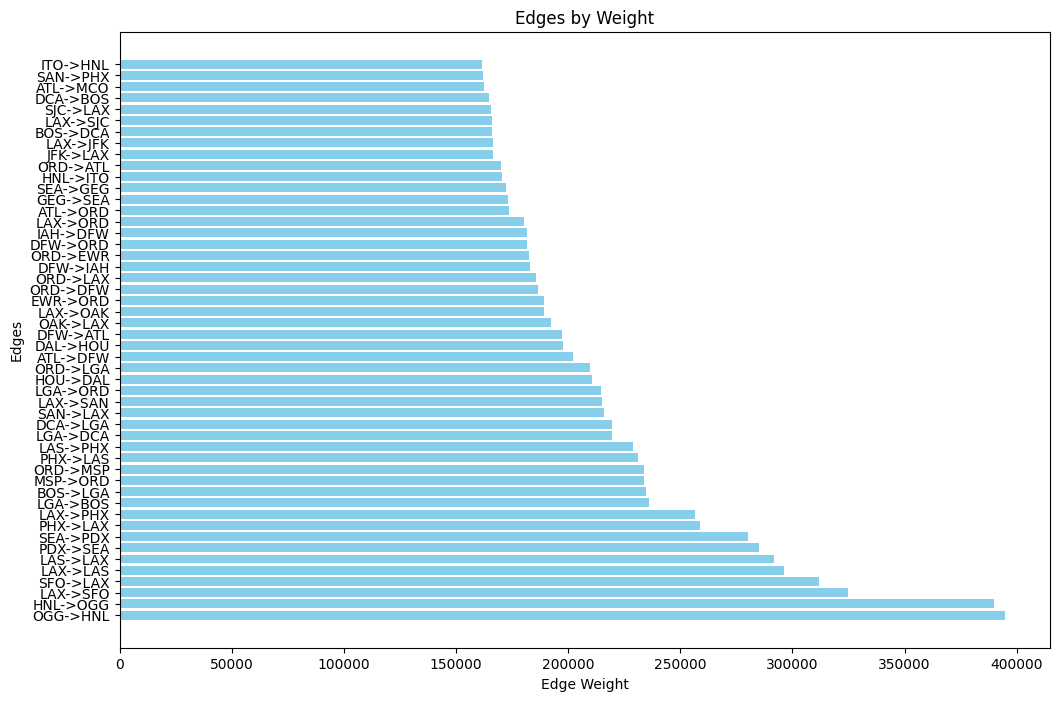

In [175]:
edges_with_weights = [(f"{u}->{v}", data['weight']) for u, v, data in flight_net.edges(data=True) if 'weight' in data]
    
sorted_edges = sorted(edges_with_weights, key=lambda x: x[1], reverse=True)
    
edge_labels, edge_weights = zip(*sorted_edges[:50])
    
# Plot Edges by Weight
plt.figure(figsize=(12, 8))
plt.barh(edge_labels, edge_weights, color='skyblue')
plt.xlabel("Edge Weight")
plt.ylabel("Edges")
plt.title(f"Edges by Weight")
plt.show()

In [176]:
sorted_edges[-50:]

[('LXN->GRI', 1),
 ('MAE->VIS', 1),
 ('PBF->YIP', 1),
 ('WMH->SGF', 1),
 ('MHE->MSY', 1),
 ('MHL->MSY', 1),
 ('SGH->DAY', 1),
 ('SGH->ORD', 1),
 ('SGH->TUL', 1),
 ('SGH->YIP', 1),
 ('MMT->YIP', 1),
 ('MYF->VGT', 1),
 ('MZZ->BNA', 1),
 ('MZZ->CSV', 1),
 ('MZZ->OKC', 1),
 ('RND->COS', 1),
 ('RND->PAM', 1),
 ('VWD->VIS', 1),
 ('OH2->RFD', 1),
 ('OH2->YIP', 1),
 ('OH5->YIP', 1),
 ('SAC->LAX', 1),
 ('SAC->PUB', 1),
 ('SAC->SAN', 1),
 ('TN3->DTW', 1),
 ('TN3->HKS', 1),
 ('TN3->YIP', 1),
 ('PHT->DET', 1),
 ('PHT->SHV', 1),
 ('PMH->RFD', 1),
 ('POU->SLN', 1),
 ('POU->WGO', 1),
 ('RID->JAN', 1),
 ('SEM->JXN', 1),
 ('SIK->YIP', 1),
 ('SLB->WFB', 1),
 ('SVH->CFV', 1),
 ('SVH->HKS', 1),
 ('SVH->MBS', 1),
 ('SVH->SHV', 1),
 ('TBR->SYR', 1),
 ('TMA->SBN', 1),
 ('TMA->SHV', 1),
 ('TN6->LRD', 1),
 ('TN6->MDT', 1),
 ('TN6->TOL', 1),
 ('WBR->GRR', 1),
 ('VWT->DTW', 1),
 ('VWT->STL', 1),
 ('VWT->YIP', 1)]

| Min Threshold | Min-Cut Value | Major Component Size | Number of Minor Components  | Total Number of Components |
|---------------|---------------|----------------------|-----------------------------|----------------------------|
| 1             | 2             | 605                  | 117                         | 118                        |
| 5             | 6             | 606                  | 117                         | 118                        |
| 10            | 11            | 603                  | 114                         | 115                        |
| 15            | 16            | 662                  | 65                          | 66                         |
| 20            | 21            | 606                  | 117                         | 118                        |
| 30            | 31            | 662                  | 65                          | 66                         |
| 50            | 51            | 606                  | 115                         | 116                        |
| 100           | 101           | 661                  | 65                          | 66                         |
| 150           | 163           | 606                  | 117                         | 118                        |
| 175           | 180           | 605                  | 118                         | 119                        |
| 200           | 212           | 660                  | 67                          | 68                         |
| 300           | -             | -                    | -                           | No valid cut found.        |


The table summarizes the results of different minimum threshold values for the cut process applied to a graph, providing insights into the graph's partitioning characteristics:

1. **Min Threshold**: The minimum edge weight considered during the min-cut algorithm. Increasing this threshold filters out smaller edges, potentially leading to larger, more significant partitions.
2. **Min-Cut Value**: The total weight of the edges removed to achieve the graph partitioning. Reflects the "cost" of separating the graph into major and minor components.
3. **Major Component Size**: The size of the largest strongly connected component (SCC) after applying the cut. A larger size suggests the graph's core remains highly connected even after the cut.
4. **Number of Minor Components**: The count of smaller SCCs resulting from the graph partitioning. A higher number indicates that the graph has many disconnected small clusters after the cut.
5. **Total Number of Components**: The sum of the major component and all minor components.

**Conclusions**:
- **Lower thresholds** (1 - 10): Retain most edges, resulting in a larger major component and a smaller number of minor components. These thresholds reveal the highly connected structure of the graph.
- **Higher thresholds** (50 - 200): The higher threshold could decrese the total number of SCCs but it happens time to time without any specific explanation.
- **Threshold Limits** (300): At very high thresholds there are no valid cuts found, indicating that the graph does not have sufficient edge weights meeting the threshold criteria.

Given the structure of the flight network, there is no feasible "minimum number of flights between airports" that can effectively separate the original network into two disconnected subgraphs. This limitation arises from the presence of a single dominant major component with an overwhelming number of flights as edges.

While it is technically possible to "merge" all minor components into one partition, this approach does not yield a meaningful or balanced division. The major component dominates the network with an immense number of connections (some exceeding 400,000), leaving the second partition to manage only a handful of airports with significantly fewer connections.

This disparity highlights the inherent challenge of dividing the network for optimal management by two companies. One company would control a vast, highly connected network, while the other would oversee a much smaller and less significant subset. Consequently, this approach is not optimal for achieving a balanced division of the network.